In [ ]:
# pip install tensorflow

In [31]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

- **Problem** : I have an imbalanced dataset with 500 original videos and 5,000 fake videos that I want to use for deepfake detection. Extracting frames from each video would result in far more fake frames, skewing the training distribution.
- **Solution** : To mitigate this class imbalance while retaining diversity, I can restrict the number of frames per fake video. For example, sampling only 10 frames evenly across each fake video results in 5,000 fake frames to match the 500 original videos. This maintains equal class representation during training.
- Another possible solution is data augmentation but considering the storage in mind this is the best possible option we have if this doesn't work then we will use data augmentation.

- This the V2 of the code for deep fake detector
- main change introduced we introduced the capability to split the videos into frames and selecting the frames based on variance rather than selecting them randomly
- The key is to ensure that these frames are representative of the entire video. You can select frames evenly spaced throughout the video, or use a more sophisticated method like selecting frames that have the most variance or are most representative of the content.

## video ---> frame splitting

In [32]:
import cv2
import os
import numpy as np

def extract_faces_with_variance(video_path, output_folder, label, max_frames=None):
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    try:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Unable to open video: {video_path}")
            return

        frame_variance = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            var = np.var(gray_frame)
            frame_variance.append((var, frame))

        cap.release()

        # Select frames based on the max_frames parameter
        if max_frames and max_frames > 0:
            frame_variance.sort(key=lambda x: x[0], reverse=True)
            selected_frames = frame_variance[:max_frames]
        else:
            selected_frames = frame_variance

        faces_detected = False
        count = 0
        for _, frame in selected_frames:
            faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5)
            for (x, y, w, h) in faces:
                faces_detected = True
                face = frame[y:y + h, x:x + w]
                resized_face = cv2.resize(face, (224, 224))
                output_path = os.path.join(output_folder, f"{label}_{video_name}_face_{count}.jpg")
                cv2.imwrite(output_path, resized_face)
                count += 1

        if not faces_detected:
            print(f"No faces detected in {video_path}")

    except Exception as e:
        print(f"An error occurred while processing {video_path}: {e}")


In [33]:

# Example usage:
# real_video_path = "original"
# fake_video_path = "fake"
# og_folder = "images/real"
# fake_folder = "images/fake"
real_video_path = "real_videos"
fake_video_path="fake_videos"
real_output_folder = "train/real"
fake_output_folder="train/fake"
real_max_frames=50
fake_max_frames=50
# Extract faces from real videos
for video_file in os.listdir(real_video_path):
    video_path = os.path.join(real_video_path, video_file)
    # print(f"Processing video: {video_path}")
    extract_faces_with_variance(video_path, real_output_folder, label="real",max_frames=real_max_frames)

# Extract faces from fake videos
for video_file in os.listdir(fake_video_path):
    video_path = os.path.join(fake_video_path, video_file)
    extract_faces_with_variance(video_path, fake_output_folder, label="fake",max_frames=fake_max_frames)

## Model

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Image dimensions
img_width, img_height = 128, 128  # Adjust based on your dataset

train_data_dir = 'train/'  # Path to the parent folder containing 'original' and 'fake' folders
batch_size = 8

# Data generator for training
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% of data for validation

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [58]:
train_generator.image_shape

(128, 128, 3)

In [59]:

# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # use 'softmax' for more than two classes
])
tf.config.run_functions_eagerly(True)

In [60]:


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              run_eagerly=True,)


In [61]:
train_generator.samples

160

In [62]:

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


Epoch 1/3


20/20 [==============================] - 9s 438ms/step - loss: 0.5920 - accuracy: 0.6625 - val_loss: 0.2774 - val_accuracy: 1.0000
Epoch 2/3
20/20 [==============================] - 8s 368ms/step - loss: 0.3448 - accuracy: 0.8250 - val_loss: 0.3329 - val_accuracy: 0.9750
Epoch 3/3
20/20 [==============================] - 9s 476ms/step - loss: 0.3529 - accuracy: 0.8062 - val_loss: 0.3746 - val_accuracy: 0.6000


In [63]:

# Save the model
model.save('deepfake_detection_model.h5')

In [64]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, DenseNet201, Xception, EfficientNetB4, NASNetLarge
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, VGG19, NASNetMobile,VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Model names
model_names = ["InceptionV3", "DenseNet201", "Xception", "EfficientNetB4", "NASNetLarge",
               "ResNet50", "InceptionResNetV2", "VGG19", "NASNetMobile","VGG16"]

# List to store models
models = []

# Loop through each model
for name in model_names:
    base_model = None

    if name == "InceptionV3":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "DenseNet201":
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "Xception":
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "EfficientNetB4":
        base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "NASNetLarge":
        base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "InceptionResNetV2":
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "VGG19":
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "NASNetMobile":
        base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif name == "VGG16":
        base_model=VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    # Create model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Append model to the list
    models.append(model)

# Train each model
for i, model in enumerate(models):
    print(f"\nTraining Model: {model_names[i]}")
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=3,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )

    # Save each model
    model.save(f"{model_names[i]}_transfer_learning_model.h5")



Training Model: InceptionV3
Epoch 1/3
20/20 [==============================] - 29s 1s/step - loss: 1.1549 - accuracy: 0.7437 - val_loss: 2.3396 - val_accuracy: 0.5000
Epoch 2/3
20/20 [==============================] - 29s 1s/step - loss: 0.3274 - accuracy: 0.8750 - val_loss: 1.4783 - val_accuracy: 0.6500
Epoch 3/3
20/20 [==============================] - 29s 1s/step - loss: 0.0722 - accuracy: 0.9812 - val_loss: 0.1111 - val_accuracy: 0.9500

Training Model: DenseNet201
Epoch 1/3
20/20 [==============================] - 61s 3s/step - loss: 0.8021 - accuracy: 0.6938 - val_loss: 0.2663 - val_accuracy: 0.8250
Epoch 2/3
20/20 [==============================] - 62s 3s/step - loss: 0.2011 - accuracy: 0.9187 - val_loss: 0.3708 - val_accuracy: 0.7000
Epoch 3/3
20/20 [==============================] - 59s 3s/step - loss: 0.0861 - accuracy: 0.9688 - val_loss: 0.2597 - val_accuracy: 0.9000

Training Model: Xception
Epoch 1/3
20/20 [==============================] - 44s 2s/step - loss: 0.3383 - ac

In [65]:
model_names

['InceptionV3',
 'DenseNet201',
 'Xception',
 'EfficientNetB4',
 'NASNetLarge',
 'ResNet50',
 'InceptionResNetV2',
 'VGG19',
 'NASNetMobile',
 'VGG16']

5/5 [==============================] - 4s 851ms/step
            Model  Accuracy  Precision  Recall  F1 Score     AUC
0     InceptionV3     0.450   0.444444    0.40  0.421053  0.4425
1     DenseNet201     0.550   0.562500    0.45  0.500000  0.6225
2        Xception     0.475   0.473684    0.45  0.461538  0.4675
3  EfficientNetB4     0.500   0.000000    0.00  0.000000  0.5675
4     NASNetLarge     0.550   0.550000    0.55  0.550000  0.5050
5           VGG19     0.550   0.571429    0.40  0.470588  0.4775
6    NASNetMobile     0.475   0.444444    0.20  0.275862  0.4675
7           VGG16     0.300   0.300000    0.30  0.300000  0.3000


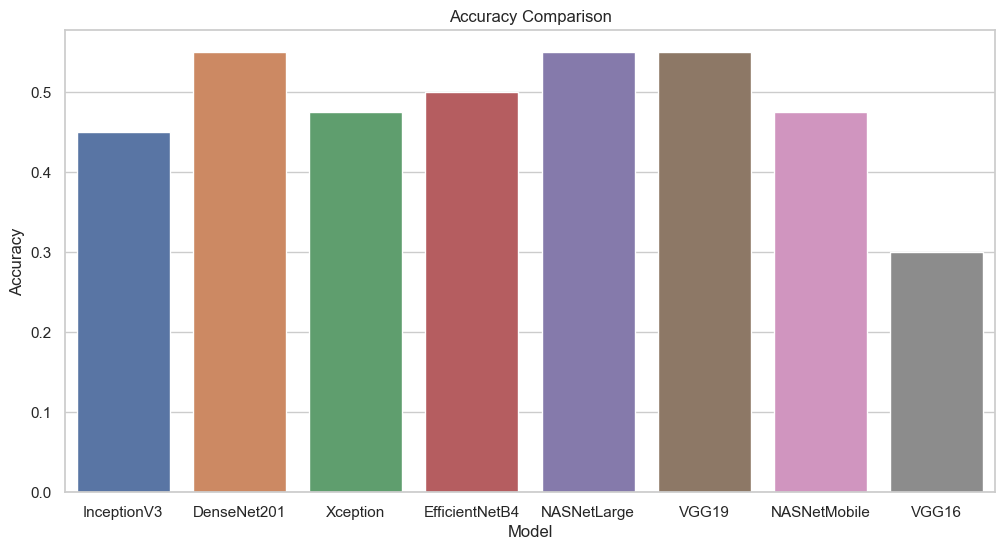

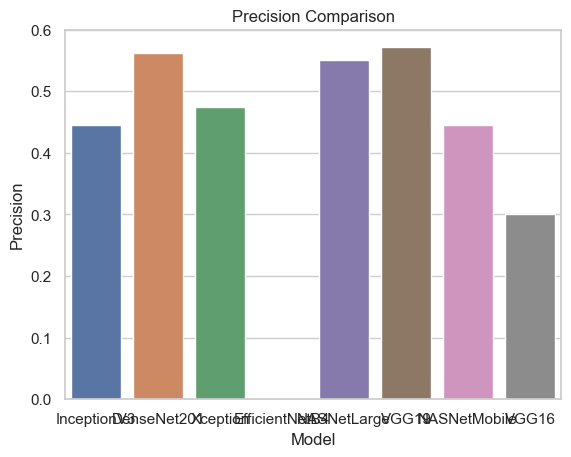

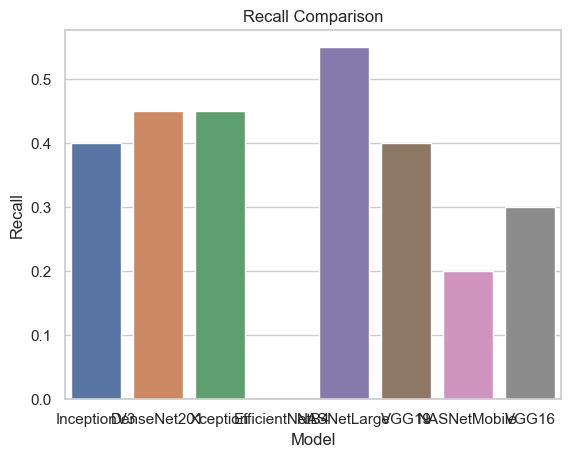

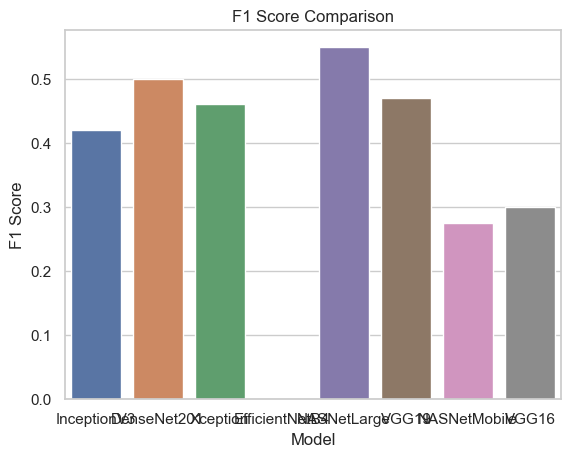

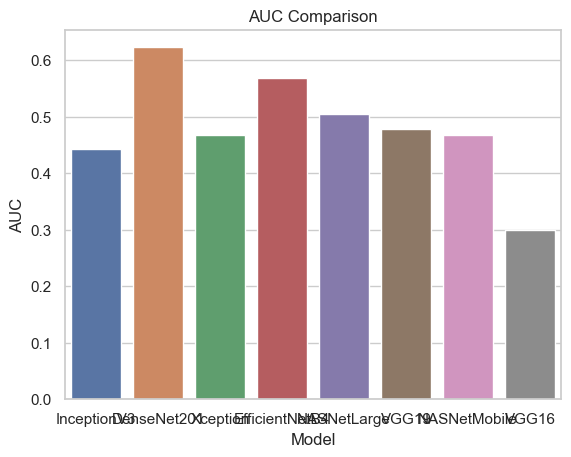

In [66]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# ["ResNet50","InceptionResNetV2"] -- getting error as customlscalelayer not defined
model_names = ["InceptionV3", "DenseNet201", "Xception", "EfficientNetB4", "NASNetLarge", "VGG19", "NASNetMobile","VGG16"]

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])

# Loop through each model
for model_name in model_names:
    # Load the saved model with custom objects
    loaded_model = tf.keras.models.load_model(f"{model_name}_transfer_learning_model.h5",
                                              custom_objects={'relu6': tf.nn.relu6})  # Add more if necessary

    # Predictions on the validation set
    y_pred = loaded_model.predict(validation_generator)
    y_pred_binary = np.round(y_pred)

    # True labels
    y_true = validation_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred)

    # Append results to DataFrame
    results_df = results_df.append({"Model": model_name, "Accuracy": accuracy,
                                    "Precision": precision, "Recall": recall,
                                    "F1 Score": f1, "AUC": auc}, ignore_index=True)

# Display the results DataFrame
print(results_df)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]

for metric in metrics:
    sns.barplot(x="Model", y=metric, data=results_df)
    plt.title(f"{metric} Comparison")
    plt.show()


## Verification

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

def extract_frames(video_path, size=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frame = img_to_array(frame)
        frame = np.expand_dims(frame, axis=0)
        frames.append(frame)
    cap.release()
    return np.vstack(frames)

def predict_video(video_path, model):
    frames = extract_frames(video_path)
    # Assuming that your model was trained with normalized images
    frames = frames.astype('float32') / 255.0
    predictions = model.predict(frames)
    avg_prediction = np.mean(predictions)
    return 'FAKE' if avg_prediction > 0.5 else 'REAL'

# Load your trained model
model = load_model('deepfake_detection_model.h5')

# Path to the new video
new_video_path = 'id9_0009.mp4'

# Predict
video_label = predict_video(new_video_path, model)
print(f"The video is predicted as: {video_label}")
